## This model version is used to train data from a glyphosate using data from the Hammamatsu spec sensor.
### Input data = 100 bands (50 from the dispersion spectrum + 50 from the emission spectrum)
### Number of samples at this point is 63 (in the range 0 to 1000 ppm) per group. Three groups of samples were obtained 1 on 10-17-25, and 2 on 10-18-25.

In [1]:
# Import modules
import os

# --- Step 1: Force CPU Usage (MUST be first) ---
# This ensures deterministic computations by avoiding the MPS GPU backend.
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
import numpy as np
import random

# --- Step 2: Set All Random Seeds ---
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

print("Forcing CPU-only execution for reproducibility. ✅")
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler, RobustScaler
# from tensorflow.keras.callbacks import EarlyStopping

import csv
# Misc
# from itertools import islice
# import plotly.express as px

Forcing CPU-only execution for reproducibility. ✅
Num GPUs Available:  0


## Inference functions


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy import stats

def get_metrics(y_test,y_pred):
    # Evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    #r2 = r2_score(y_test, y_pred)
    regression_result = stats.linregress(y_test, y_pred)
    r2 = regression_result.rvalue ** 2

    print(f"Mean Absolute Error (MAE): {mae:.3f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
    print(f"R-squared (R2): {r2:.3f}")
    
    return(mae,rmse,r2)

def model_predict(dynamic_filename,X_test_scaled,y_test):
    # Load the saved model from the file
    print(f"Loading model from: {dynamic_filename}")
    loaded_model = tf.keras.models.load_model('/Users/andresmr/Documents/Glyphosate_sensor_CFATA/models/'+dynamic_filename)
    print("Model loaded successfully.")

    X_test = X_test_scaled
    # Use the loaded model to make predictions on the test data
    y_pred = loaded_model.predict(X_test)

    # The output of .predict() is often a 2D array, so we flatten it to a 1D array
    y_pred = y_pred.flatten()

    # LOD & LOQ
    is_blank = (y_test <0.001)
    y_pred_blanks = y_pred[is_blank]
    print(y_pred_blanks)
    mu_blank = np.mean(y_pred_blanks)
  
    sigma_blank = np.std(y_pred_blanks) 
    print(mu_blank,sigma_blank)
    lod = mu_blank + (3 * sigma_blank)
    loq = mu_blank + (10 * sigma_blank)

    print(f"(LOD): {lod:.4f} ppm")
    print(f"(LOQ): {loq:.4f} ppm")

    # Evaluation metrics
    mae,rmse,r2 = get_metrics(y_test,y_pred)
    
    # 2. Create the plot
    fig, ax = plt.subplots(figsize=(8, 8))

    # Scatter plot of actual vs. predicted values
    ax.scatter(y_test, y_pred, alpha=0.6, edgecolors="w", label='Predictions')

    # Add a line for perfect predictions (y=x)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, 'r--', alpha=0.75, zorder=0, label='Perfect Predictions')

    # 3. Add metrics to the plot
    # Using LaTeX for R^2
    metrics_text = (
        f"$R^2$ = {r2:.3f}\n"
        f"MAE = {mae:.3f}\n"
        f"RMSE = {rmse:.3f}"
    )
    # Place text box in the top-left corner
    ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))

    # 4. Final plot settings
    ax.set_xlabel("Actual Values (y_test)", fontsize=12)
    ax.set_ylabel("Predicted Values (y_pred)", fontsize=12)
    ax.set_title("Actual vs. Predicted Values", fontsize=16)
    ax.set_aspect('equal', adjustable='box')
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

### Read main file with samples

In [3]:
# Create augmentations with original data

# File path with measurements 
# file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/ESP32_code/samples/10-21-2025_G1_R3.csv'
file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/samples/G1G2R1.csv'
# Open file with data.
with open(file_path, 'r') as file:
    reader = csv.reader(file)
    n = 0
    data = []
    for i,row in enumerate(reader):
        data.append(row)
        # if n<1015:
        #     data.append(row)
        # n+=1
#len(data)

split = [] # The data from '10-21-2025_G1_R1.csv' will only be used for training and validation
split.append(len(data)) # original samples
split.append(len(data)) # train and val set
split.append((len(data)*0.2)/len(data)) # val set percentage
split.append(0) # test set

# Shuffle the rows of the data list in-place
random.shuffle(data)

print(len(data))
print(split)


261
[261, 261, 0.2, 0]


### Review structure

In [ ]:
import matplotlib.pyplot as plt
#print(len(data),len(data[0]))
y_data = []
for i,y_i in enumerate(data): 
    y_row = []
    #print(len(y_i))
    for j in y_i[3:]:
        #print(j)
        if j != '-':
            y_row.append(float(j))
    y_data.append(y_row)
    
#print(len(y_data[0]))
x_data = np.linspace(400,950,len(y_data[0]))
#print(len(x_data))

plt.figure(figsize=(10, 10))
prev_cc = y_data[0][1]
b_color = 0.0
r_color = 1.0
for i in range(len(data)):
    cc = data[i][1]
    curr_cc = y_data[i][1]
    if prev_cc != curr_cc:
        b_color = 0.0 + (i/len(data))
        r_color = 1.0 - (i/len(data))
    plt.plot(x_data,y_data[i], label='Sample Data: '+ str(cc), color=(r_color,0.6,b_color))
    prev_cc = curr_cc
plt.xlabel('Band?')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

### Augmentations for training data

In [4]:
# Create augmentations with original data

# File path with measurements; group one with one sample per concentration, three replicate measurements
# file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/ESP32_code/samples/10-21-2025_G1_R3.csv'
file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/samples/G1G2R1.csv'

# Create list variables
nombres = []
invalues = []
outvalues = []

# Create list for augmentations
filaau = ["A"] * 110
aug = []

variants = 7 # 7 m
noise1 = 0.06 # 0.05
noise2 = 0.03 # 0.02
# noise1b = -0.05
# noise2b = -0.02
# Open file with data
with open(file_path, 'r') as file:
    reader = csv.reader(file)
    n = 0
    for row in reader:
        if n<(split[1]-1):
            filaau[1]=row[1] # row[1] is glyphosate concentration (true)
        # Start augmentations 
            # +-X% noise augmentation (m variants per sample)
            for j in range(0,variants):
              filaau[0]=row[0]+"_"+ str(j) # filaau contains string name sample + j-index (m variants j-indices per row/sample).
              # first block of x data
              for i in range(3,53): # Iterate over column 3 to 53 in csv per j iteration (m variants j-indices)
                filaau[i]=float(row[i])
                filaau[i]=filaau[i]*random.uniform(1-noise1, 1-noise1)
                #filaau[i] = filaau[i] + random.uniform(-noise1, noise1)
              filaau[53]='-'
              # second block of x data
              for i in range(54,104):
                filaau[i]=float(row[i])
                filaau[i]=filaau[i]*random.uniform(1-noise1, 1-noise1)
              # # Save augmentation
              aug.append(filaau.copy())

            #+-X noise augmentations%
            for j in range(variants,variants*2):
              filaau[0]=row[0]+"_"+ str(j)
              for i in range(3,53):
                filaau[i]=float(row[i])
                filaau[i]=filaau[i]*random.uniform(1-noise2, 1-noise2)
              filaau[53]='-'
              # Second block of data
              for i in range(54,104):
                filaau[i]=float(row[i])
                filaau[i]=filaau[i]*random.uniform(1-noise2, 1-noise2)
              aug.append(filaau.copy())
        n+=1
len(data), split[1], len(aug)

(261, 261, 3640)

## X and y data

In [5]:
# X and y data lists
_inputs = []
_targets = []

# Add first block of data (original)
for i in range(int(split[1])):
        row_data = []
        for j in range(3,104):
                if j!= 53:
                        row_data.append(float(data[i][j]))
        _inputs.append(row_data)
        _targets.append(float(data[i][1]))
# Add second block of data (augmentations for main and second file)
for i in range(len(aug)):
        row_data = []
        for j in range(3,104):
                if j!= 53:                        
                        row_data.append(float(aug[i][j]))
        _inputs.append(row_data)
        _targets.append(float(aug[i][1]))

# Convert list to arrays
X_data = np.array(_inputs)
y_data= np.array(_targets)

print(len(X_data), len(y_data))
print(len(data))
print(len(X_data[0]))

# Data normalization
#scaler = StandardScaler()
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_data)
print(split[2])

3901 3901
261
100
0.2


## Use PCA (95%

Forma original de X_data: (3901, 100)
Forma original de y_data: (3901,)
------------------------------
Forma de X_train original (escalada): (3901, 100)
Forma de X_train reducida (PCA): (3901, 3)
------------------------------
Número de componentes seleccionados: 3
Varianza total explicada: 0.9710

¡Datos listos para el entrenamiento!
Datos de entrenamiento: X_train_pca, y_train
Datos de prueba: X_test_pca, y_test
Epoch 1/100


/opt/miniconda3/envs/gly_models/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 497.0621 - mae: 497.0621 - val_loss: 476.7673 - val_mae: 476.7673
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - loss: 427.1977 - mae: 427.1977 - val_loss: 356.3498 - val_mae: 356.3498
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - loss: 294.1533 - mae: 294.1533 - val_loss: 272.7607 - val_mae: 272.7607
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - loss: 244.0074 - mae: 244.0074 - val_loss: 243.6936 - val_mae: 243.6936
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 219.3596 - mae: 219.3596 - val_loss: 224.4686 - val_mae: 224.4686
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - loss: 204.4084 - mae: 204.4084 - val_loss: 214.9729 - val_mae: 214.9729
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - loss: 196.2612 - mae: 196.2612 - val_loss: 207.3289 - val_mae: 207.3289
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - loss: 190.7338 - mae: 190.7338 - val_loss: 200.9136 - val_mae: 200.913

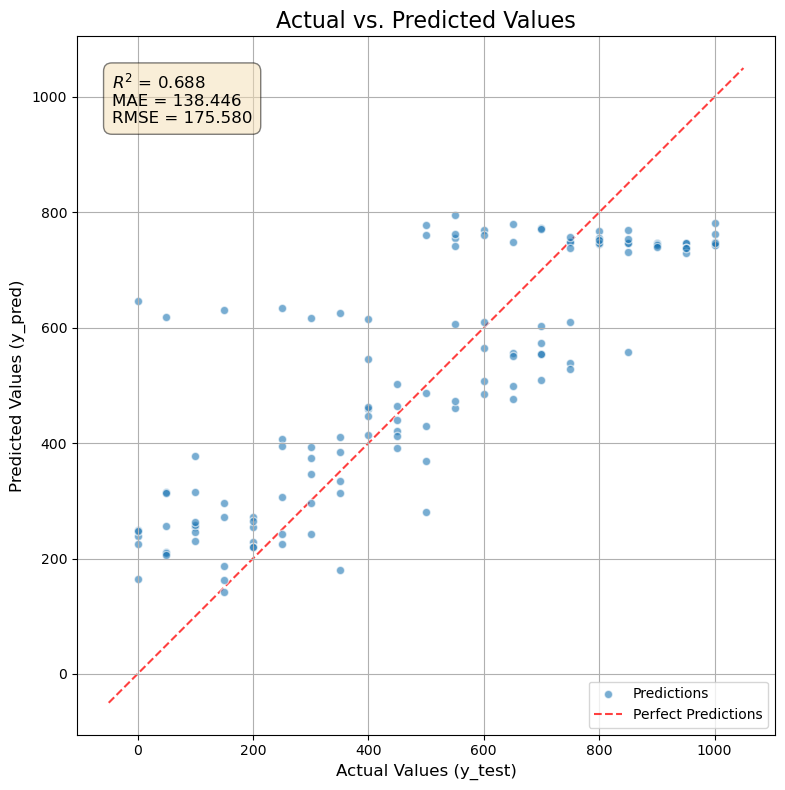

In [6]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split


print(f"Forma original de X_data: {X_data.shape}")
print(f"Forma original de y_data: {y_data.shape}")
print("-" * 30)

# --- 4. Aplicar PCA ---
# Inicializa PCA. n_components=0.95 le dice a PCA que
# seleccione automáticamente el número de componentes
# que explican el 95% de la varianza.
pca = PCA(n_components=0.95)

# Ajusta PCA SÓLO en los datos de entrenamiento escalados
X_train_pca = pca.fit_transform(X_train_scaled)

# --- 5. Revisar los resultados ---
print(f"Forma de X_train original (escalada): {X_train_scaled.shape}")
print(f"Forma de X_train reducida (PCA): {X_train_pca.shape}")
print("-" * 30)
print(f"Número de componentes seleccionados: {pca.n_components_}")
print(f"Varianza total explicada: {np.sum(pca.explained_variance_ratio_):.4f}")

# --- Listo para entrenar ---
print("\n¡Datos listos para el entrenamiento!")
print("Datos de entrenamiento: X_train_pca, y_train")
print("Datos de prueba: X_test_pca, y_test")

# AHORA puedes usar X_train_pca y y_train para entrenar tu modelo.
# Por ejemplo:
# from sklearn.linear_model import LogisticRegression
# model = LogisticRegression()
# model.fit(X_train_pca, y_train)
# accuracy = model.score(X_test_pca, y_test)
# print(f"Precisión del modelo en datos PCA: {accuracy:.4f}")



import time

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_pca, y_data, test_size=split[2], random_state=42
)

# Model definition
model = tf.keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(len(X_train[0]),)), # origianl sequence: 64,64,8,1
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='linear')
])

adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) # original value: 0.009

# Optimizer and loss              
model.compile(optimizer=adam_optimizer,
              loss='mean_absolute_error',
              metrics=['mae'])
              #loss='mean_squared_error',
              #metrics=['mse'])

# Model training
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=64, # original: 32
    validation_data=(X_val, y_val),
    verbose=1
)

# Get the last validation loss from the training history
final_val_loss = history.history['val_loss'][-1]

# Get the current date and time
timestamp = time.strftime("%Y%m%d-%H%M%S")

# Create a descriptive filename using an f-string
dynamic_filename = f"model_loss-{final_val_loss:.4f}_{timestamp}.keras"

# Save the model with the new dynamic name
model.save('/Users/andresmr/Documents/Glyphosate_sensor_CFATA/models/'+dynamic_filename)

# Print the name to see what was saved
print(f"Model saved successfully as: {dynamic_filename}")

# INFERENCE ON TEST SET

# File path with measurements 
file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/samples/G2R2R3.csv'
#file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/ESP32_code/samples/G2.csv'


# Open file with data. 
with open(file_path, 'r') as file:
    reader = csv.reader(file)
    n = 0
    test_data = []
    for i,row in enumerate(reader):
        test_data.append(row)
        # if n>=int(split[1]-1):
        #     test_data.append(row)
        # n+=1

_test_inputs = []
_test_targets = []

# Add first block of data (original)
for i in range(len(test_data)):
        row_data = []
        for j in range(3,104):
                if j!= 53:
                #if j>53:                       
                        row_data.append(float(test_data[i][j]))
        _test_inputs.append(row_data)
        _test_targets.append(float(test_data[i][1]))

# Convert list to arrays
X_test = np.array(_test_inputs)
y_test= np.array(_test_targets)

print(len(X_test), len(y_test), len(X_test[0]))
X_test_scaled = scaler.transform(X_test)  # Note: just .transform(), not .fit_transform()

# Aplica la MISMA transformación PCA a los datos de prueba escalados
X_test_pca = pca.transform(X_test_scaled)

model_predict(dynamic_filename,X_test_pca,y_test)


## New training code

In [ ]:
import time

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_scaled, y_data, test_size=split[2], random_state=42
)

# Model definition
model = tf.keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(len(X_data[0]),)), # origianl sequence: 64,64,8,1
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='linear')
])

adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) # original value: 0.009

# Optimizer and loss              
model.compile(optimizer=adam_optimizer,
              loss='mean_absolute_error',
              metrics=['mae'])
              #loss='mean_squared_error',
              #metrics=['mse'])

# Model training
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=64, # original: 32
    validation_data=(X_val, y_val),
    verbose=1
)

# Get the last validation loss from the training history
final_val_loss = history.history['val_loss'][-1]

# Get the current date and time
timestamp = time.strftime("%Y%m%d-%H%M%S")

# Create a descriptive filename using an f-string
dynamic_filename = f"model_loss-{final_val_loss:.4f}_{timestamp}.keras"

# Save the model with the new dynamic name
model.save('/Users/andresmr/Documents/Glyphosate_sensor_CFATA/models/'+dynamic_filename)

# Print the name to see what was saved
print(f"Model saved successfully as: {dynamic_filename}")

### first R

131 131 100
Loading model from: model_loss-1548.1626_20251108-103217.keras
Model loaded successfully.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[ -2.3602448  12.0039215  21.560844  -22.35521    37.167496   59.170517 ]
17.531221 26.30843
(LOD): 96.4565 ppm
(LOQ): 280.6155 ppm
Mean Absolute Error (MAE): 49.143
Root Mean Squared Error (RMSE): 62.504
R-squared (R2): 0.968


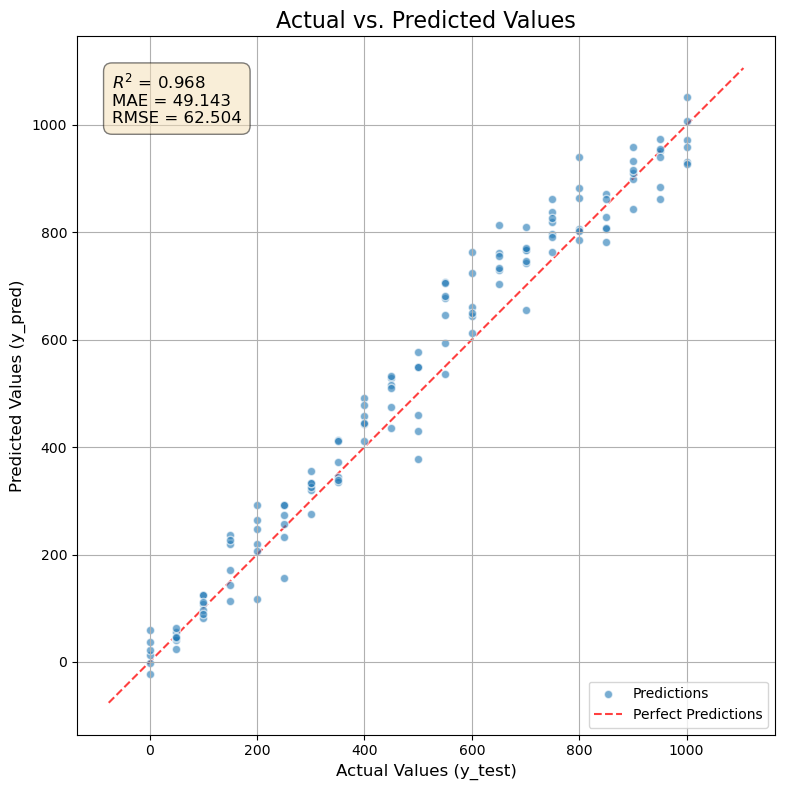

In [8]:
# File path with measurements 
file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/samples/G2R2R3.csv'
#file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/ESP32_code/samples/G2.csv'


# Open file with data. 
with open(file_path, 'r') as file:
    reader = csv.reader(file)
    n = 0
    test_data = []
    for i,row in enumerate(reader):
        test_data.append(row)
        # if n>=int(split[1]-1):
        #     test_data.append(row)
        # n+=1

_test_inputs = []
_test_targets = []

# Add first block of data (original)
for i in range(len(test_data)):
        row_data = []
        for j in range(3,104):
                if j!= 53:
                #if j>53:                       
                        row_data.append(float(test_data[i][j]))
        _test_inputs.append(row_data)
        _test_targets.append(float(test_data[i][1]))

# Convert list to arrays
X_test = np.array(_test_inputs)
y_test= np.array(_test_targets)

print(len(X_test), len(y_test), len(X_test[0]))
X_test_scaled = scaler.transform(X_test)  # Note: just .transform(), not .fit_transform()

model_predict(dynamic_filename,X_test_scaled,y_test)

### Second R

64 64 100
Loading model from: model_loss-51.0458_20251108-090106.keras
Model loaded successfully.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
[ 34.45632 133.07294  88.74841]
85.425896 40.328552
(LOD): 206.4116 ppm
(LOQ): 488.7114 ppm
Mean Absolute Error (MAE): 108.499
Root Mean Squared Error (RMSE): 125.632
R-squared (R2): 0.913


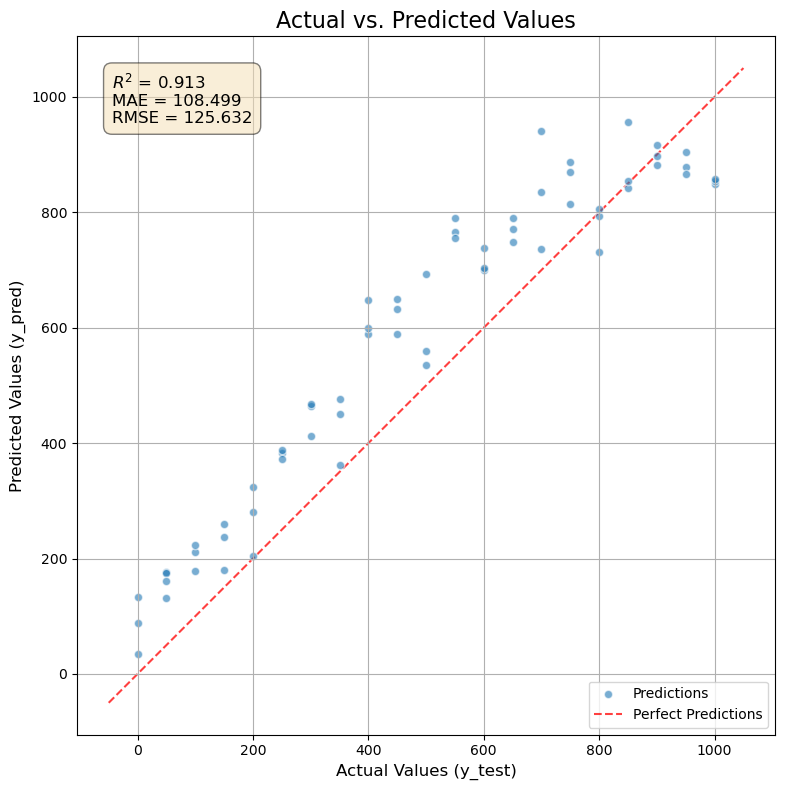

In [8]:
# File path with measurements 
file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/samples/10-26-2025_G2_R3.csv'

# Open file with data. 
with open(file_path, 'r') as file:
    reader = csv.reader(file)
    n = 0
    test_data = []
    for i,row in enumerate(reader):
        test_data.append(row)
        # if n>=int(split[1]-1):
        #     test_data.append(row)
        # n+=1

_test_inputs = []
_test_targets = []

# Add first block of data (original)
for i in range(len(test_data)):
        row_data = []
        for j in range(3,104):
                if j!= 53:
                #if j>53:                       
                        row_data.append(float(test_data[i][j]))
        _test_inputs.append(row_data)
        _test_targets.append(float(test_data[i][1]))

# Convert list to arrays
X_test = np.array(_test_inputs)
y_test= np.array(_test_targets)

print(len(X_test), len(y_test), len(X_test[0]))
X_test_scaled = scaler.transform(X_test)  # Note: just .transform(), not .fit_transform()

model_predict(dynamic_filename,X_test_scaled,y_test)


### Test set from Oct 16 (new samples)

In [11]:
# File path with measurements 
#file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/samples/all_samples.csv'
file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/new_samples.csv'
#file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/samples/sep17v2.csv'

# Open file with data. 
with open(file_path, 'r') as file:
    reader = csv.reader(file)
    n = 0
    test_data = []
    for i,row in enumerate(reader):
        test_data.append(row)
        # if n>=int(split[1]-1):
        #     test_data.append(row)
        # n+=1

_test_inputs = []
_test_targets = []

# Add first block of data (original)
for i in range(len(test_data)):
        row_data = []
        for j in range(3,104):
                if j!= 53:
                #if j>53:                       
                        row_data.append(float(test_data[i][j]))
        _test_inputs.append(row_data)
        _test_targets.append(float(test_data[i][1]))

# Convert list to arrays
X_test = np.array(_test_inputs)
y_test= np.array(_test_targets)

print(len(X_test), len(y_test), len(X_test[0]))
X_test_scaled = scaler.transform(X_test)  # Note: just .transform(), not .fit_transform()

84 84 100


Loading model from: model_loss-43.1397_20251017-163905.keras
Model loaded successfully.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Mean Absolute Error (MAE): 461.298
Root Mean Squared Error (RMSE): 531.750
R-squared (R2): -2.085


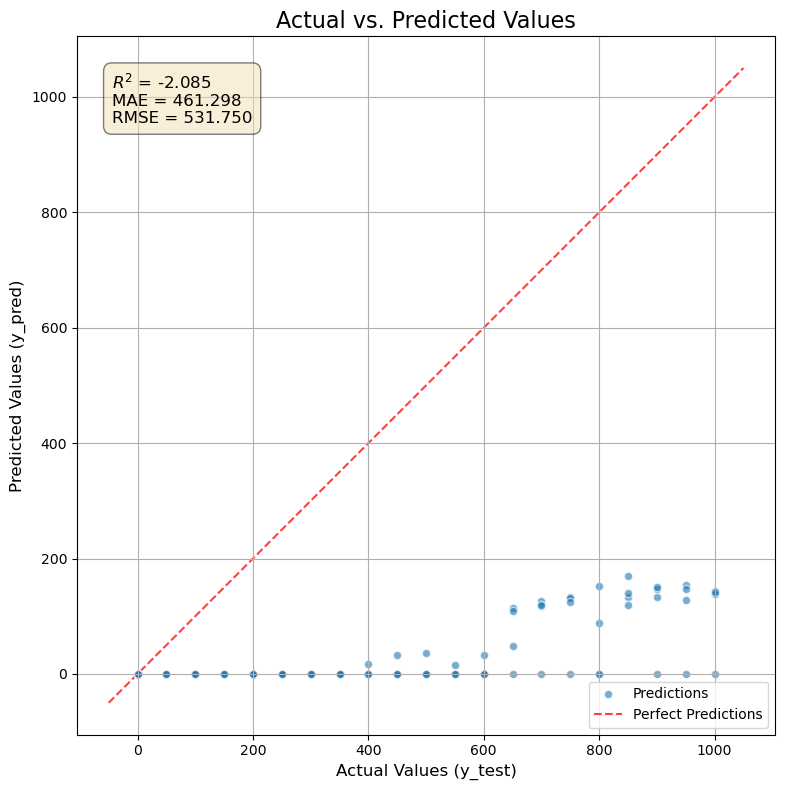

In [12]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def get_metrics(y_test,y_pred):
    # Evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Absolute Error (MAE): {mae:.3f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
    print(f"R-squared (R2): {r2:.3f}")
    
    return(mae,rmse,r2)

def model_predict(dynamic_filename,X_test_scaled,y_test):
    # Load the saved model from the file
    print(f"Loading model from: {dynamic_filename}")
    loaded_model = tf.keras.models.load_model('/Users/andresmr/Documents/Glyphosate_sensor_CFATA/models/'+dynamic_filename)
    print("Model loaded successfully.")

    X_test = X_test_scaled
    # Use the loaded model to make predictions on the test data
    y_pred = loaded_model.predict(X_test)

    # The output of .predict() is often a 2D array, so we flatten it to a 1D array
    y_pred = y_pred.flatten()


    # Evaluation metrics
    mae,rmse,r2 = get_metrics(y_test,y_pred)
    
    # 2. Create the plot
    fig, ax = plt.subplots(figsize=(8, 8))

    # Scatter plot of actual vs. predicted values
    ax.scatter(y_test, y_pred, alpha=0.6, edgecolors="w", label='Predictions')

    # Add a line for perfect predictions (y=x)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, 'r--', alpha=0.75, zorder=0, label='Perfect Predictions')

    # 3. Add metrics to the plot
    # Using LaTeX for R^2
    metrics_text = (
        f"$R^2$ = {r2:.3f}\n"
        f"MAE = {mae:.3f}\n"
        f"RMSE = {rmse:.3f}"
    )
    # Place text box in the top-left corner
    ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))

    # 4. Final plot settings
    ax.set_xlabel("Actual Values (y_test)", fontsize=12)
    ax.set_ylabel("Predicted Values (y_pred)", fontsize=12)
    ax.set_title("Actual vs. Predicted Values", fontsize=16)
    ax.set_aspect('equal', adjustable='box')
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

model_predict(dynamic_filename,X_test_scaled,y_test)

### Test set Oct 10 (a few random samples in the cc range)

13 13 100
Loading model from: model_loss-43.1397_20251010-133259.keras
Model loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Mean Absolute Error (MAE): 865.689
Root Mean Squared Error (RMSE): 1352.079
R-squared (R2): 0.366


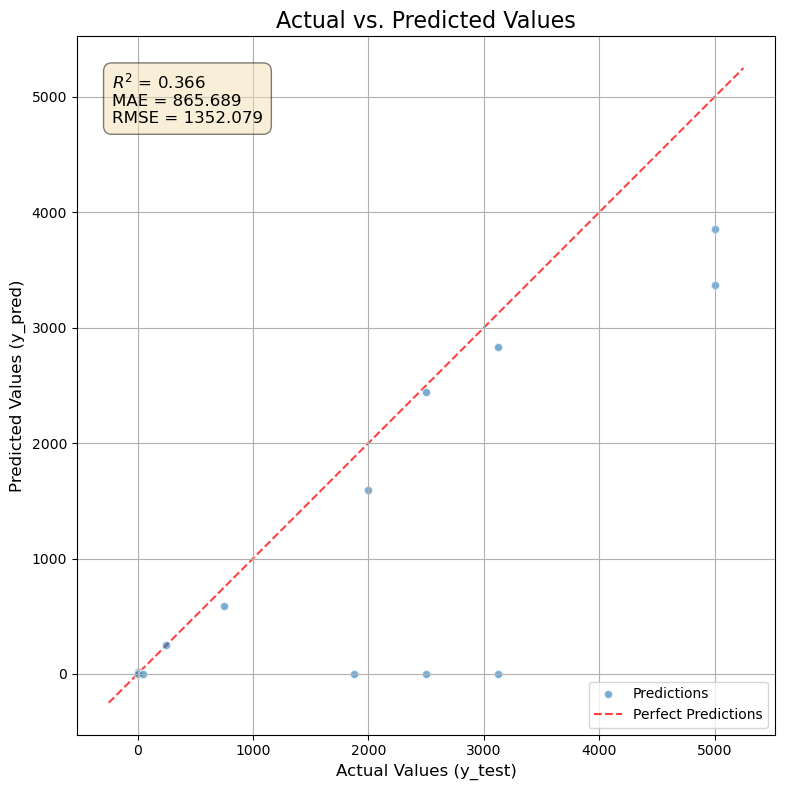

In [9]:
file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/samples/Oct10.csv'

# Open file with data. 
with open(file_path, 'r') as file:
    reader = csv.reader(file)
    n = 0
    test_data = []
    for i,row in enumerate(reader):
        test_data.append(row)
_test_inputs = []
_test_targets = []
# Add first block of data (original)
for i in range(len(test_data)):
        row_data = []
        for j in range(3,104):
                if j!= 53:                    
                        row_data.append(float(test_data[i][j]))
        _test_inputs.append(row_data)
        _test_targets.append(float(test_data[i][1]))

# Convert list to arrays
X_test = np.array(_test_inputs)
y_test= np.array(_test_targets)

print(len(X_test), len(y_test), len(X_test[0]))
X_test_scaled = scaler.transform(X_test)

model_predict(dynamic_filename,X_test_scaled,y_test)

### Test using model in sensor

Mean Absolute Error (MAE): 1577.923
Root Mean Squared Error (RMSE): 2067.534
R-squared (R2): -0.483


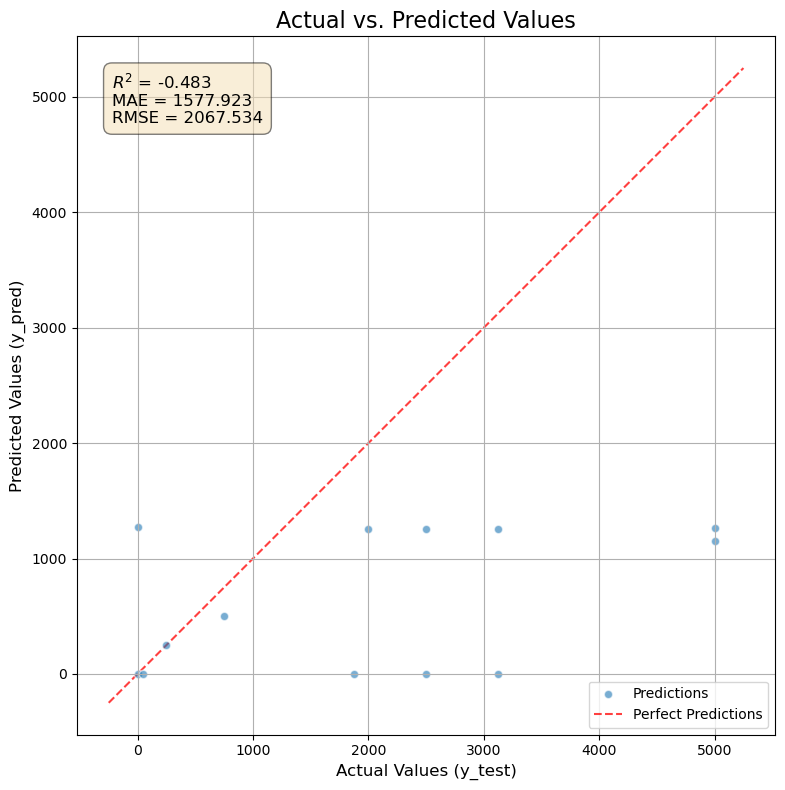

In [10]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/oct10_results.csv'

# Open file with data. 
with open(file_path, 'r') as file:
    reader = csv.reader(file)
    n = 0
    test_data = []
    for i,row in enumerate(reader):
        test_data.append(row)
_y_pred = []
_y_true = []
# Add first block of data (original)
for i in range(len(test_data)):
        _y_pred.append(float(test_data[i][1]))
        _y_true.append(float(test_data[i][0]))

mae,rmse,r2 = get_metrics(_y_true,_y_pred)

# 2. Create the plot
fig, ax = plt.subplots(figsize=(8, 8))

# Scatter plot of actual vs. predicted values
ax.scatter(_y_true, _y_pred, alpha=0.6, edgecolors="w", label='Predictions')

# Add a line for perfect predictions (y=x)
lims = [
np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'r--', alpha=0.75, zorder=0, label='Perfect Predictions')

# 3. Add metrics to the plot
# Using LaTeX for R^2
metrics_text = (
f"$R^2$ = {r2:.3f}\n"
f"MAE = {mae:.3f}\n"
f"RMSE = {rmse:.3f}"
)
# Place text box in the top-left corner
ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))

# 4. Final plot settings
ax.set_xlabel("Actual Values (y_test)", fontsize=12)
ax.set_ylabel("Predicted Values (y_pred)", fontsize=12)
ax.set_title("Actual vs. Predicted Values", fontsize=16)
ax.set_aspect('equal', adjustable='box')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
y_data_sample = y_data
# ----------------------------------------------------

# Set the style of the plot for better aesthetics
sns.set_style("whitegrid")

# Create the plot
plt.figure(figsize=(10, 6)) # Set the figure size
# Using a histogram with a Kernel Density Estimate (KDE)
sns.histplot(y_data_sample, kde=True, bins=30, color='skyblue')

# Add titles and labels for clarity
plt.title('Distribution of y_data (Compound Concentration)', fontsize=16)
plt.xlabel('Concentration', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Display the plot 📊
plt.show()

In [ ]:
#!pip install everywhereml>=0.2.12


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\algim\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [23]:
from everywhereml.code_generators.tensorflow import tf_porter

#tf_model, x_train, y_train = get_model()
# tf_porter() requires:
#   1. the neural network model
#   2. the input data (to detect the input dimensions)
#   3. the output labels (to detect the number of classes - if classification)
#
# Passing `instance_name` will create an instance of the model, so you don't have to
# `area_size` is to control how much memory to allocate for the network
# It is a trial-and-error process


#porter = tf_porter(tf_model, entradas_train, salidas_train)
porter = tf_porter(model, entradas_train, salidas_train)
cpp_code = porter.to_cpp(instance_name='glifoNN1', arena_size=10000)

#cpp_code.save('/content/gdrive/My Drive/NNglifosato2/NNmar19')

print(cpp_code)

INFO:tensorflow:Assets written to: C:\Users\algim\AppData\Local\Temp\tmpkmj07hdr\assets


INFO:tensorflow:Assets written to: C:\Users\algim\AppData\Local\Temp\tmpkmj07hdr\assets


#ifndef UUID2187630171792
#define UUID2187630171792

#include <EloquentTinyML.h>
#include <eloquent_tinyml/tensorflow.h>

#ifdef __has_attribute
#define HAVE_ATTRIBUTE(x) __has_attribute(x)
#else
#define HAVE_ATTRIBUTE(x) 0
#endif
#if HAVE_ATTRIBUTE(aligned) || (defined(__GNUC__) && !defined(__clang__))
#define DATA_ALIGN_ATTRIBUTE __attribute__((aligned(4)))
#else
#define DATA_ALIGN_ATTRIBUTE
#endif

#ifndef ARENA_SIZE
#define ARENA_SIZE 10000
#endif

/** model size = 34128 bytes **/
const unsigned char modelData[] DATA_ALIGN_ATTRIBUTE = { 0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00, 0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x94, 0x00, 0x00, 0x00, 0xec, 0x00, 0x00, 0x00, 0x6c, 0x7e, 0x00, 0x00, 0x7c, 0x7e, 0x00, 0x00, 0xfc, 0x84, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x10, 0x00, 0x00, 0x00, 0x00, 0x00, 0x0a, 0x00, 0x10, 0x00, 0x0c, 0x0

## outliers


--- Método 1: Análisis Visual (Box Plots) ---


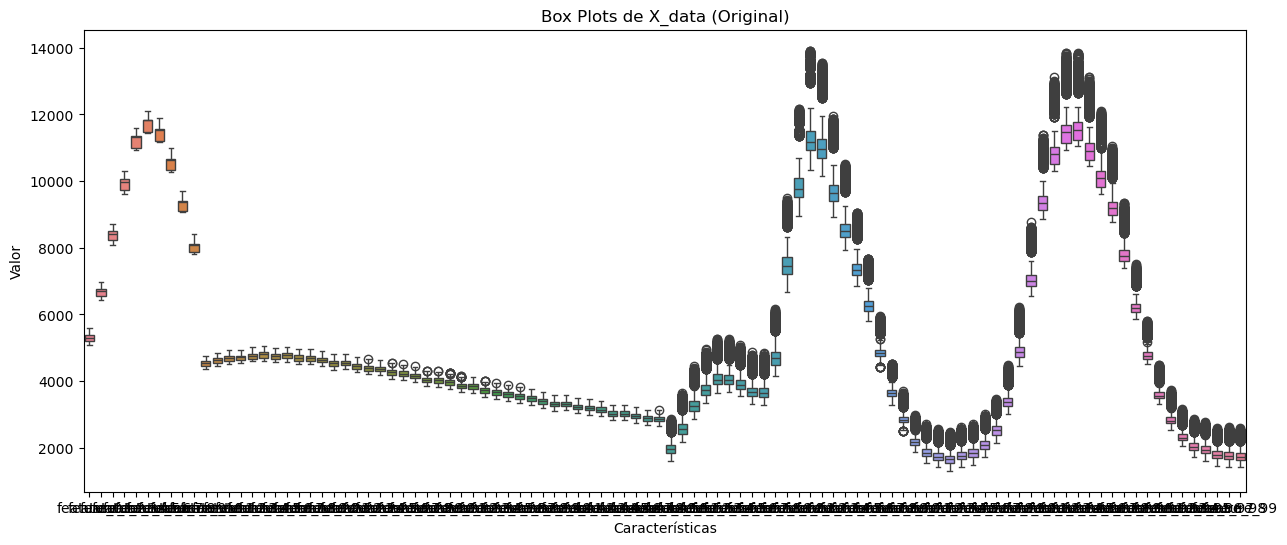

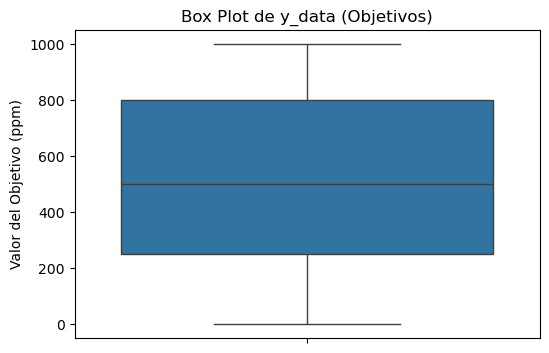


--- Método 2: Rango Intercuartílico (IQR) [Univariado] ---

No se encontraron outliers extremos en 'feature_0'.

No se encontraron outliers extremos en 'feature_1'.

No se encontraron outliers extremos en 'feature_2'.

No se encontraron outliers extremos en 'feature_3'.

No se encontraron outliers extremos en 'feature_4'.

No se encontraron outliers extremos en 'feature_5'.

No se encontraron outliers extremos en 'feature_6'.

No se encontraron outliers extremos en 'feature_7'.

No se encontraron outliers extremos en 'feature_8'.

No se encontraron outliers extremos en 'feature_9'.

No se encontraron outliers extremos en 'feature_10'.

No se encontraron outliers extremos en 'feature_11'.

No se encontraron outliers extremos en 'feature_12'.

No se encontraron outliers extremos en 'feature_13'.

No se encontraron outliers extremos en 'feature_14'.

No se encontraron outliers extremos en 'feature_15'.

No se encontraron outliers extremos en 'feature_16'.

No se encontraron outliers extr

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest

# Para facilitar el análisis, convierte X_data a un DataFrame de Pandas
# (Las columnas de tus datos de radiación)
X_df = pd.DataFrame(X_data, columns=[f'feature_{i}' for i in range(X_data.shape[1])])
# --------------------------------------------------


print("--- Método 1: Análisis Visual (Box Plots) ---")
# Un box plot muestra visualmente los outliers (como puntos)

# A. Box plot para X_data (Características)
plt.figure(figsize=(15, 6))
sns.boxplot(data=X_df)
plt.title("Box Plots de X_data (Original)")
plt.ylabel("Valor")
plt.xlabel("Características")
plt.show()

# B. Box plot para y_data (Objetivos)
# ¡No olvides analizar tus objetivos! Outliers aquí son muy problemáticos.
plt.figure(figsize=(6, 4))
sns.boxplot(data=y_data)
plt.title("Box Plot de y_data (Objetivos)")
plt.ylabel("Valor del Objetivo (ppm)")
plt.show()


print("\n--- Método 2: Rango Intercuartílico (IQR) [Univariado] ---")
# Este método es robusto contra outliers.
# Un valor es un outlier si está 1.5 * IQR por debajo de Q1 o por encima de Q3.

for column in X_df.columns:
    Q1 = X_df[column].quantile(0.25)
    Q3 = X_df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)
    
    # Encuentra los índices de los outliers en esta columna
    outlier_indices = X_df[(X_df[column] < lower_bound) | (X_df[column] > upper_bound)].index
    
    if len(outlier_indices) > 0:
        print(f"\nOutliers encontrados en '{column}' (Índices: {list(outlier_indices)}):")
        print(X_df.loc[outlier_indices, [column]])
    else:
        print(f"\nNo se encontraron outliers extremos en '{column}'.")

# También puedes hacer lo mismo para y_data
Q1_y = np.quantile(y_data, 0.25)
Q3_y = np.quantile(y_data, 0.75)
IQR_y = Q3_y - Q1_y
lower_bound_y = Q1_y - (1.5 * IQR_y)
upper_bound_y = Q3_y + (1.5 * IQR_y)
outlier_indices_y = np.where((y_data < lower_bound_y) | (y_data > upper_bound_y))[0]
print(f"\nOutliers encontrados en 'y_data' (Índices: {list(outlier_indices_y)}):")
print(y_data[outlier_indices_y])


print("\n--- Método 3: Isolation Forest [Multivariado] ---")
# Este método encuentra puntos que son "anómalos" considerando
# todas las características a la vez.

# 'contamination' es la proporción esperada de outliers. 'auto' funciona bien.
# También puedes poner un valor, ej: 0.05 (para 5%)
iso_forest = IsolationForest(contamination='auto', random_state=42)

# Entrena con los datos originales X_data
# NOTA: Este algoritmo también puede funcionar bien con datos escalados,
# pero para detección, el original es más interpretable.
y_pred_outliers = iso_forest.fit_predict(X_data)

# El modelo predice -1 para outliers y 1 para "inliers" (puntos normales)
outlier_indices_multi = np.where(y_pred_outliers == -1)[0]

if len(outlier_indices_multi) > 0:
    print(f"Outliers multivariados encontrados en los índices: {outlier_indices_multi}")
    print("Datos de esos outliers (X_data):")
    print(X_df.iloc[outlier_indices_multi])
else:
    print("No se encontraron outliers multivariados significativos.")